In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import PolynomialFeatures, Normalizer, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
#import holidays

import statsmodels.api as sm
import warnings


%matplotlib inline

/home/frodos/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке! Вам понадобится много признаков. Некоторые из них у вас уже есть — это:
<ol>
<li>идентификатор географической зоны
<li>дата и время
<li>количество поездок в периоды, предшествующие прогнозируемому
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
<li>Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!
</ol>



Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования y^T+1|T, другая для y^T+2|T и т.д.

<ol>Чтобы сдать задание, выполните следующую последовательность действий.
<li>Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:
<ul>
<li>идентификатор географической зоны — категориальный
<li>год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так (done)
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA (done)
<li>сами значения прогнозов ARIMA y^T+i|TARIMA
<li>количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li>количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
</ul>
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании y^T+i|T,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.

<li>Разбейте каждую из шести выборок на три части:

    обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
    тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
    итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016

<li>Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

    допускала попарные взаимодействия между признаками
    была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)

<li>Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16y^T|T+ir−yT+ir.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

<li>Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

<li>Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

<li>Загрузите ноутбук в форму.

Подгружаем данные

In [2]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

In [3]:
df.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
2016-06-30 19:00:00,116,190,135,132,395,308,401,336,496,260,...,2,44,4,297,311,104,9,142,96,1
2016-06-30 20:00:00,104,142,149,141,333,368,390,385,560,247,...,1,27,7,288,344,103,24,209,145,0
2016-06-30 21:00:00,151,162,145,135,359,422,460,541,672,259,...,2,21,9,287,307,185,9,213,142,1
2016-06-30 22:00:00,106,168,103,125,317,476,405,508,578,259,...,3,19,5,358,387,169,12,206,146,0
2016-06-30 23:00:00,85,130,86,113,256,428,483,531,631,210,...,9,0,7,323,110,147,38,173,119,0


In [4]:
# эта функция возвращает фичи, общие для всех колонок (временные гармоники, даты)
def getCommonFeature(Kw=5,Ka=2,addHolidays = True):
    #parameters:
    #  Kw is number of weeks harmonics
    #  Ka is number of annual harmonics
    # holidays - add bool feature for holidays
    
    
    df2 = pd.DataFrame(index=index1)
    df2 = df2.assign(linear = (df2.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    if addHolidays:  
        us_holidays = holidays.UnitedStates(state="NY")
        # категориальная переменная для выходных дней
        df2 = df2.assign(holidays = df2.index.date)
        df2.holidays =  df2.loc[:,'holidays'].apply(lambda x: 1 if x in us_holidays else 0)

    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        df2['weekCos'+str(ind)]= np.cos(np.pi*df2.linear*ind/168);
        df2['weekSin'+str(ind)]= np.sin(np.pi*df2.linear*ind/168);
    
    for ind in range(1,Ka+1):
        df2['yearCos'+str(ind)]= np.cos(2*np.pi*df2.linear*ind/8766);
        df2['yearSin'+str(ind)]= np.sin(2*np.pi*df2.linear*ind/8766);

    # добавляем числовое и категориальные свойства для дней недели
    df2 = df2.assign(dayOfWeek = df2.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(df2.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
               index = df2.index)      
    df2 = df2.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    df2 = df2.assign(month = df2.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(df2.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                  index = df2.index)      
    df2 = df2.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    df2 = df2.assign(year = df.index.year)

    # добавляем день месяца (вещественный)
    df2 = df2.assign(day = df.index.day)

    # добавляем час (вещественный и категориальный)
    df2 = df2.assign(hour = df.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(df2.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
               index = df2.index)      
    df2 = df2.merge(Hours,left_index=True,right_index=True)
    return df2

In [5]:
# эта функция сохраняет данные в файл
def saveResults(rdf, fName, delta = 30):
    rnd = np.round

    f = open(fName,'w')
    f.writelines('id,y\n')

    for ind, row in rdf.reset_index().iterrows():
        historyStart = row.date

        if historyStart > datetime.datetime(2016,6,30,17):
            continue

        s0 = str(row.region)+'_'+ str(datetime.datetime.strftime(historyStart, "%Y-%m-%d"))+ '_'+ str(historyStart.hour)

        s1 = s0 +'_1,'+str(rnd(row.get('y1_pr'))+delta) + '\n'
        f.writelines(s1)

        s2 = s0 +'_2,'+str(rnd(row.get('y2_pr'))+delta) + '\n'
        f.writelines(s2)

        s3 = s0 +'_3,'+str(rnd(row.get('y3_pr'))+delta) + '\n'
        f.writelines(s3)

        s4 = s0 +'_4,'+str(rnd(row.get('y4_pr'))+delta) + '\n'
        f.writelines(s4)

        s5 = s0 +'_5,'+str(rnd(row.get('y5_pr'))+delta) + '\n'
        f.writelines(s5)

        s6 = s0 +'_6,'+str(rnd(row.get('y6_pr'))+delta) + '\n'
        f.writelines(s6)

    f.close()    

In [6]:
def processSeries(df,Kh = 6, Kp = 2):
    """
    Обработка одного данного ряда 
    parameters:
        df - начальный датафрейм, из которого выберем для обработки один ряд
        tReg - название ряда, который надо обработать
        Kh - количество отслеживаемых прошлых суточных лагов "назад"
        Kp - количество отслеживаемых прошлых периодических лагов (период 24 часа)

    """
 

    tDf = df.copy()
    for timeLag in np.arange(1,Kh+1):
        name = 'hourLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag)

        

    for timeLag in np.arange(1,Kp+1):
        name = 'periodicLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag*24)


    tDf.fillna(0,inplace=True)    

    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
    tDf.loc[:,'mean12'] = tDf.y.rolling(window = 12, min_periods = 1).mean()
    tDf.loc[:,'mean24'] = tDf.y.rolling(window = 24, min_periods = 1).mean()
    tDf.loc[:,'meanWeek'] = tDf.y.rolling(window = 168, min_periods = 1).mean()
    tDf.loc[:,'meanMonth'] = tDf.y.rolling(window = 720, min_periods = 1).mean()

    
     
    tDf.loc[:,'max12'] = tDf.y.rolling(window = 12, min_periods = 1).max()
    tDf.loc[:,'max24'] = tDf.y.rolling(window = 24, min_periods = 1).max()
    tDf.loc[:,'maxWeek'] = tDf.y.rolling(window = 168, min_periods = 1).max()
    tDf.loc[:,'maxMonth'] = tDf.y.rolling(window = 720, min_periods = 1).max()

    
    
    tDf.loc[:,'min12'] = tDf.y.rolling(window = 12, min_periods = 1).min()
    tDf.loc[:,'min24'] = tDf.y.rolling(window = 24, min_periods = 1).min()
    tDf.loc[:,'minWeek'] = tDf.y.rolling(window = 168, min_periods = 1).min()
    tDf.loc[:,'minMonth'] = tDf.y.rolling(window = 720, min_periods = 1).min()

        
    return tDf

In [7]:
# вычисление ошибки
def calcMAE(inpDf):
    score = 0
    testDf = inpDf.reset_index()
    for k, v in saveDict.iteritems():
        score += MAE(testDf.loc[:,k],testDf.loc[:,v])
    score = score / 6.0    
    print score

In [8]:
# create multyindex dataframe
index1 = df.index # time is first index
index2 = df.columns.values.astype(int)

mIndex = pd.MultiIndex.from_product([index2, index1],names=['region','date'])
df_test = pd.DataFrame(columns=['y'],index = mIndex)

In [9]:
idx = pd.IndexSlice

In [10]:
# create MultiIndex dataframe with target variables    
for k in index2:
    pos = idx[k,:]
    df_test.loc[idx[k,:],'y'] = df.loc[:,str(k)].values
    # create target variables
    df_test.loc[pos,'y1'] = df_test.loc[pos,'y'].shift(-1).fillna(0)
    df_test.loc[pos,'y2'] = df_test.loc[pos,'y'].shift(-2).fillna(0)
    df_test.loc[pos,'y3'] = df_test.loc[pos,'y'].shift(-3).fillna(0)
    df_test.loc[pos,'y4'] = df_test.loc[pos,'y'].shift(-4).fillna(0)
    df_test.loc[pos,'y5'] = df_test.loc[pos,'y'].shift(-5).fillna(0)
    df_test.loc[pos,'y6'] = df_test.loc[pos,'y'].shift(-6).fillna(0)
    
df_test.head()    

y     y1     y2    y3    y4    y5    y6
region date                                                          
1075   2014-01-01 00:00:00   87   92.0  108.0  77.0  47.0  22.0  10.0
       2014-01-01 01:00:00   92  108.0   77.0  47.0  22.0  10.0  18.0
       2014-01-01 02:00:00  108   77.0   47.0  22.0  10.0  18.0  19.0
       2014-01-01 03:00:00   77   47.0   22.0  10.0  18.0  19.0  28.0
       2014-01-01 04:00:00   47   22.0   10.0  18.0  19.0  28.0  37.0

In [11]:
# create common features
commonFeatures = getCommonFeature(addHolidays=False)
commonFeatures.index.name = 'date'
commonFeatures.head()

,linear,weekCos1,weekSin1,weekCos2,weekSin2,weekCos3,weekSin3,weekCos4,weekSin4,weekCos5,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,0.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 01:00:00,1.0,0.999825,0.018699,0.999301,0.037391,0.998427,0.056070,0.997204,0.074730,0.995632,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 02:00:00,2.0,0.999301,0.037391,0.997204,0.074730,0.993712,0.111964,0.988831,0.149042,0.982566,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 03:00:00,3.0,0.998427,0.056070,0.993712,0.111964,0.985871,0.167506,0.974928,0.222521,0.960917,...,0,0,0,0,0,0,0,0,0,0
2014-01-01 04:00:00,4.0,0.997204,0.074730,0.988831,0.149042,0.974928,0.222521,0.955573,0.294755,0.930874,...,0,0,0,0,0,0,0,0,0,0


### Подгрузим и отобразим данные по погоде

In [ ]:
#weatherDf = pd.read_pickle('../data/weatherDf.pcl')
#weatherDf.index.name = 'date'

In [ ]:
weatherDf = weatherDf[~weatherDf.duplicated()]

In [ ]:
plt.figure(figsize=[15,10])

plt.subplot(311)
weatherDf.temp_val.plot()
plt.title('Temperature')
plt.xlabel('')
plt.ylabel('C')
plt.xticks([])

plt.subplot(312)
weatherDf.precip.plot()
plt.title('Precipitation')
plt.xlabel('')
plt.xticks([])
plt.ylabel('h')

plt.subplot(313)
weatherDf.snow.plot()
plt.title('Snow')
plt.ylabel('h')

In [ ]:
commonFeatures = commonFeatures.merge(weatherDf,left_index=True,right_index=True,how='left')


In [ ]:
commonFeatures[commonFeatures.duplicated()]

In [12]:
# join common features and add unique ones for each subgroup 
final = pd.DataFrame()
for k in index2:
    # create tatget variables
    pos = idx[k,:]
    tmp = processSeries(df_test.loc[pos,:].join(commonFeatures),Kh = 12, Kp = 4)
    final = pd.concat([final,tmp])

In [13]:
dropList = ['y1','y2','y3','y4','y5','y6','date','region'] # колонки, которые не надо учитывать в регрессоре
targetList= ['y1','y2','y3','y4','y5','y6']                # целевые переменные для регрессоров 

In [14]:
# define time frames
startTrain = '2016-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-05-31 23:00:00'
endTest   = '2016-06-30 23:00:00'

In [15]:
# dataframe to save prediction
resIndex = pd.MultiIndex.from_product([final.index.levels[0],pd.date_range(start=startTest,end=endTest,freq='1H')],
                                    names=['region','date'])
df_res = pd.DataFrame(columns=['y1','y1_pr','y2','y2_pr','y3','y3_pr','y4','y4_pr','y5','y5_pr','y6','y6_pr'],index = resIndex)
df_res2 = pd.DataFrame(columns=['y1','y1_pr','y2','y2_pr','y3','y3_pr','y4','y4_pr','y5','y5_pr','y6','y6_pr'],index = resIndex)
saveDict = {'y1':'y1_pr','y2':'y2_pr','y3':'y3_pr','y4':'y4_pr','y5':'y5_pr','y6':'y6_pr'}

In [16]:
# final.to_pickle('finalDf.pcl')
final = pd.read_pickle('finalDf.pcl')

In [17]:
final.head()

y     y1     y2    y3    y4    y5    y6  linear  \
region date                                                                     
1075   2014-01-01 00:00:00   87   92.0  108.0  77.0  47.0  22.0  10.0     0.0   
       2014-01-01 01:00:00   92  108.0   77.0  47.0  22.0  10.0  18.0     1.0   
       2014-01-01 02:00:00  108   77.0   47.0  22.0  10.0  18.0  19.0     2.0   
       2014-01-01 03:00:00   77   47.0   22.0  10.0  18.0  19.0  28.0     3.0   
       2014-01-01 04:00:00   47   22.0   10.0  18.0  19.0  28.0  37.0     4.0   

                            weekCos1  weekSin1    ...      meanWeek  \
region date                                       ...                 
1075   2014-01-01 00:00:00  1.000000  0.000000    ...     87.000000   
       2014-01-01 01:00:00  0.999825  0.018699    ...     89.500000   
       2014-01-01 02:00:00  0.999301  0.037391    ...     95.666667   
       2014-01-01 03:00:00  0.998427  0.056070    ...     91.000000   
       2014-01-01 04:00:00  0.997204  0.074730    ...     82.200000   

                            meanMonth  max12  max24  maxWeek  maxMonth  min12  \
region date                                                                     
1075   2014-01-01 00:00:00  87.000000   87.0   87.0     87.0      87.0   87.0   
       2014-01-01 01:00:00  89.500000   92.0   92.0     92.0      92.0   87.0   
       2014-01-01 02:00:00  95.666667  108.0  108.0    108.0     108.0   87.0   
       2014-01-01 03:00:00  91.000000  108.0  108.0    108.0     108.0   77.0   
       2014-01-01 04:00:00  82.200000  108.0  108.0    108.0     108.0   47.0   

                            min24  minWeek  minMonth  
region date                                           
1075   2014-01-01 00:00:00   87.0     87.0      87.0  
       2014-01-01 01:00:00   87.0     87.0      87.0  
       2014-01-01 02:00:00   87.0     87.0      87.0  
       2014-01-01 03:00:00   77.0     77.0      77.0  
       2014-01-01 04:00:00   47.0     47.0      47.0  

[5 rows x 97 columns]

In [ ]:
# выберу первую группу и протестирую на ней регрессор и саримах

In [52]:
setDf = final.loc[idx[final.index.levels[0].values[0],startTrain:endTest],:]
setDf.reset_index(inplace=True,level=0)

In [53]:
dropList = ['y1','y2','y3','y4','y5','y6','date'] # колонки, которые не надо учитывать в регрессоре

train = setDf.loc[startTrain:endValidation,:].reset_index()
test  = setDf.loc[startTest:endTest,:].reset_index()

linReg = linear_model.Ridge()
linReg.fit(train.drop(dropList,axis=1),train.loc[:,'y1'])
t = linReg.predict(setDf.loc[startTrain:endTest,:].reset_index().drop(dropList,axis=1))

In [54]:
ts = pd.Series(t,index=setDf.loc[startTrain:endTest,:].index)
setDf = setDf.merge(ts.shift(1).fillna(0).to_frame(name='regressor'),left_index=True,right_index=True)
setDf = setDf.assign(y1_sarimax = 0).assign(y2_sarimax = 0).assign(y3_sarimax = 0).assign(y4_sarimax = 0).assign(y5_sarimax = 0).assign(y6_sarimax = 0)
setDf.head()

,region,y,y1,y2,y3,y4,y5,y6,linear,weekCos1,...,min24,minWeek,minMonth,regressor,y1_sarimax,y2_sarimax,y3_sarimax,y4_sarimax,y5_sarimax,y6_sarimax
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,1075,80,91.0,90.0,32.0,24.0,11.0,7.0,17520.0,0.623490,...,1.0,0.0,0.0,0.000000,0,0,0,0,0,0
2016-01-01 01:00:00,1075,91,90.0,32.0,24.0,11.0,7.0,9.0,17521.0,0.608761,...,1.0,0.0,0.0,50.452750,0,0,0,0,0,0
2016-01-01 02:00:00,1075,90,32.0,24.0,11.0,7.0,9.0,18.0,17522.0,0.593820,...,1.0,0.0,0.0,65.177748,0,0,0,0,0,0
2016-01-01 03:00:00,1075,32,24.0,11.0,7.0,9.0,18.0,22.0,17523.0,0.578671,...,1.0,0.0,0.0,66.185428,0,0,0,0,0,0
2016-01-01 04:00:00,1075,24,11.0,7.0,9.0,18.0,22.0,27.0,17524.0,0.563320,...,1.0,0.0,0.0,23.444506,0,0,0,0,0,0


(736117.0, 736118.0)

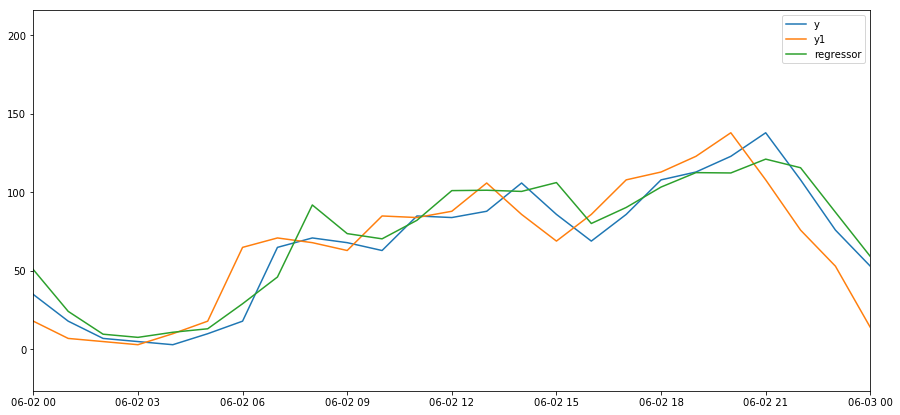

In [55]:
plt.figure(figsize=[15,7])
plt.plot(setDf.y)
plt.plot(setDf.y1)
plt.plot(setDf.regressor)
plt.legend(['y','y1','regressor'])
plt.xlim(['2016-06-02','2016-06-03'])

In [56]:
from itertools import product
ps = range(3, 0, -1)
d  = 1
qs = range(3, 0, -1)
Ps = range(2, 0, -1)
D  = 1
Qs = range(2, 0, -1)
pList = list(product(ps, qs, Ps, Qs))

In [57]:
# подбираем параметры
for params in pList:
    print params

    # обучаем SARIMAX модель
    print 'Learn SARIMAX'
    try:
        mSARIMA=sm.tsa.statespace.SARIMAX(setDf.loc[startTrain:endValidation,'y'], order=[params[0], d, params[1]],
                                          seasonal_order=(params[2], D, params[3], 24),
                                          exog = setDf.loc[startTrain:endValidation,'regressor'], enforce_invertibility = True).fit(disp=1);
    except Exception as inst:
        print type(inst)     
        print inst
    else:
        print 'Model is ready'
        break
        
        

(3, 3, 2, 2)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 3, 2, 1)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 3, 1, 2)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 3, 1, 1)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 2, 2, 2)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 2, 2, 1)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(3, 2, 1, 2)
Learn SARIMAX
<type 'exceptions.ValueError'>
Non-stationa

/home/frodos/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Model is ready


In [59]:
# создаём новую модель, которую будет использовать для предсказания
# Для чего такой финт ушами - не понимаю до сих пор
try:
    model_fitted = sm.tsa.statespace.SARIMAX(setDf.loc[startTrain:endValidation,'y'],
                                             order=[params[0], d, params[1]],
                                             seasonal_order=(params[2], D, params[3], 24),
                                             exog = setDf.loc[startTrain:endValidation,'regressor'],
                                             enforce_invertibility = True).filter(mSARIMA.params)
except Exception as inst:
    print 'Can not create the model'
    print inst

In [64]:
# проходим по всему диапазону дат предсказаний
print 'Make prediction'
predictionRange = pd.date_range(startTrain,endTest, freq='H')
for historyStart in predictionRange[:-6]:
    firstLag = historyStart+datetime.timedelta(hours = 1)
    lastLag  = historyStart+datetime.timedelta(hours = 6)
    # prediction
    try:
        predicted_data = model_fitted.predict(firstLag, lastLag, dynamic=True,
                                              exog = setDf.loc[firstLag:lastLag,'regressor'])
    except Exception as inst:
        print 'Prediction error'
        print inst
    else:
        print predicted_data
        setDf.loc[historyStart,['y1_sarimax','y2_sarimax','y3_sarimax','y4_sarimax','y5_sarimax','y6_sarimax']] = predicted_data.values 
            
        # save results
        #resDf.loc[tsId,firstLag].y = predicted_data
        #err += (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().sum()
        #resDf.loc[tsId,firstLag].err = (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().mean()

Make prediction
2016-01-01 01:00:00    130.295153
2016-01-01 02:00:00    144.978125
2016-01-01 03:00:00    145.982845
2016-01-01 04:00:00    103.364810
2016-01-01 05:00:00     94.110591
2016-01-01 06:00:00     95.062032
Freq: H, dtype: float64
2016-01-01 02:00:00    105.695353
2016-01-01 03:00:00    106.699789
2016-01-01 04:00:00     64.081816
2016-01-01 05:00:00     54.827538
2016-01-01 06:00:00     55.778982
2016-01-01 07:00:00     65.118826
Freq: H, dtype: float64
2016-01-01 03:00:00    91.009381
2016-01-01 04:00:00    48.391294
2016-01-01 05:00:00    39.137041
2016-01-01 06:00:00    40.088462
2016-01-01 07:00:00    49.428307
2016-01-01 08:00:00    64.793779
Freq: H, dtype: float64
2016-01-01 04:00:00   -10.599493
2016-01-01 05:00:00   -19.854174
2016-01-01 06:00:00   -18.902660
2016-01-01 07:00:00    -9.562902
2016-01-01 08:00:00     5.802573
2016-01-01 09:00:00   -17.072022
Freq: H, dtype: float64
2016-01-01 05:00:00    14.734417
2016-01-01 06:00:00    15.686182
2016-01-01 07:00:0

KeyboardInterrupt: 

In [ ]:


# собственно, сам регрессор
for reg in final.index.levels[0].values:
    train = final.loc[idx[reg,startTrain:endValidation],:].reset_index()
    test  = final.loc[idx[reg,startTest:endTest],:].reset_index()
    for target in targetList:
        linReg.fit(train.drop(dropList,axis=1),train.loc[:,target])
        prediction = linReg.predict(test.drop(dropList,axis=1))
        prediction[prediction<0] = 0
        df_res.loc[idx[reg,:], target] = test.loc[:,target].values
        df_res.loc[idx[reg,:], saveDict.get(target)] = prediction
    print reg #,' ', calcMAE(df_res)    
df_res.head()        

In [ ]:
# собственно, сам регрессор
for reg in final.index.levels[0].values:
    train = final.loc[idx[reg,startTrain:endValidation],:].reset_index()
    test  = final.loc[idx[reg,startTest:endTest],:].reset_index()
    for target in targetList:
        linReg.fit(train.drop(dropList,axis=1),train.loc[:,target])
        prediction = linReg.predict(test.drop(dropList,axis=1))
        prediction[prediction<0] = 0
        df_res.loc[idx[reg,:], target] = test.loc[:,target].values
        df_res.loc[idx[reg,:], saveDict.get(target)] = prediction
    print reg #,' ', calcMAE(df_res)    
df_res.head()        

In [ ]:
calcMAE(df_res)
#saveResults(df_res,fName='02Aug.csv',delta=0)

На момент загрузки - 30е место в лидерборде со счётом 23.41763 (ник Frodos)

Теперь добавим нормализатор к регрессору.

In [ ]:
linReg = linear_model.Ridge()

ppl = Pipeline([('norm',MinMaxScaler()),('features',PolynomialFeatures(degree=2)),('regressor',linReg)])

for reg in final.index.levels[0].values:
    X_train = final.loc[idx[reg,startTrain:endValidation],:].reset_index().drop(dropList,axis=1)
    X_test  = final.loc[idx[reg,startTest:endTest],:].reset_index().drop(dropList,axis=1)
    
    for target in targetList:
        y_train = final.loc[idx[reg,startTrain:endValidation],:].reset_index().loc[:,target]
        y_test  = final.loc[idx[reg,startTest:endTest],:].reset_index().loc[:,target]
    
        ppl.fit(X_train,y_train)
        prediction = ppl.predict(X_test)
        prediction[prediction<0] = 0
        df_res2.loc[idx[reg,:], target] = y_test.values
        df_res2.loc[idx[reg,:], saveDict.get(target)] = prediction
    print reg #,' ', calcMAE(df_res)    
df_res2.head() 

calcMAE(df_res2)

In [ ]:
saveResults(df_res2,fName='13Aug.csv',delta=0)